## Import libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *
from collections import defaultdict
import csv
from datetime import datetime
import os


## Read and preprocess data


In [23]:
def load_data(file_path):
    data_dict = dict()

    with open(file_path) as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row['Numéro du groupe'] != '':
                heures, minutes, _ = map(int, row['TransitTime'].split(':')) 
                total_minutes = heures * 60 + minutes
                data_dict[int(float(row['Numéro du groupe']))] = (
                    int(float(row['Femmes'])),
                    int(float(row['Hommes'])),
                    int(float(row['WCHR'])),
                    total_minutes
                )

    return data_dict

# Load data for each file

file_names = ["DataSeating 2024.csv","22Oct.csv","23Oct.csv","24Oct.csv","30Oct.csv", "5Nov.csv", "7Nov.csv"]
data_directory = 'data'
# for eachy dictionary : dict[Numéro du groupe : (Femmes, Hommes, WCHR, TransitTime)]
Oct21, Oct22,Oct23, Oct24, Oct30, Nov5, Nov7= [load_data(os.path.join(data_directory, file)) for file in file_names]

Transforming data to access each passenger's Id


In [24]:
def create_passengers_dict(data):
    passengers_dict = {}
    j = 1

    for group_num, group_data in data.items():
        weights = {'Femmes': 70, 'Hommes': 85, 'WCHR': 100}  # Weight per passenger

        # Extracting data
        femmes, hommes, wchr, total_minutes = group_data

        # Enumerating passengers
        for _ in range(femmes + hommes + wchr):
            if femmes > 0:
                weight = weights['Femmes']
                passengers_dict[j] = {'gender': 'Femmes', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                femmes -= 1
            elif hommes > 0:
                weight = weights['Hommes']
                passengers_dict[j] = {'gender': 'Hommes', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                hommes -= 1
            else:
                weight = weights['WCHR']
                passengers_dict[j] = {'gender': 'WCHR', 'group': group_num, 'weight': weight,
                                      'connection_time': total_minutes}
                wchr -= 1
            j += 1

    return passengers_dict

Passengers_Oct21 = create_passengers_dict(Oct21)
Passengers_Oct22 = create_passengers_dict(Oct22)
Passengers_Oct23 = create_passengers_dict(Oct23)
Passengers_Oct24 = create_passengers_dict(Oct24)
Passengers_Oct30 = create_passengers_dict(Oct30)
Passengers_Nov5 = create_passengers_dict(Nov5)
Passengers_Nov7 = create_passengers_dict(Nov7)

# Example usage for Nov5
print(Passengers_Nov5)

{1: {'gender': 'Femmes', 'group': 1, 'weight': 70, 'connection_time': 0}, 2: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 3: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 4: {'gender': 'Hommes', 'group': 2, 'weight': 85, 'connection_time': 60}, 5: {'gender': 'Femmes', 'group': 3, 'weight': 70, 'connection_time': 165}, 6: {'gender': 'Hommes', 'group': 3, 'weight': 85, 'connection_time': 165}, 7: {'gender': 'Femmes', 'group': 4, 'weight': 70, 'connection_time': 0}, 8: {'gender': 'Hommes', 'group': 4, 'weight': 85, 'connection_time': 0}, 9: {'gender': 'WCHR', 'group': 4, 'weight': 100, 'connection_time': 0}, 10: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 11: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 12: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 13: {'gender': 'Femmes', 'group': 6, 'weight': 70, 'connection_time': 0}, 14: {'gender': 'Hommes', 'group': 6, 'weig

# Static model

In [25]:
# Function to create optimization model and variables

ranks = 29  # number of rows in the aircraft
ns = 7 * ranks  # number of seats

def create_model_and_variables(passengers_dict):
    n = len(passengers_dict)  # number of passengers

    m = Model('statique')  # Model initialization

    # Adding variables
    S = {(i, j): m.addVar(vtype=GRB.BINARY, name=f'j{i}') for i in range(1, n + 1) for j in range(1, ns + 1)}

    # Adding constraints
    # Max. 1 seat per passenger
    for j in range(1, ns + 1):
        m.addConstr(quicksum(S[(i, j)] for i in range(1, n + 1)) <= 1, name="PassengerMax")

    # Each passenger has one and only one seat
    for i in range(1, n + 1):
        m.addConstr(quicksum(S[(i, j)] for j in range(1, ns + 1)) == 1, name="SeatMax")

    # The central aisle is left free
    for i in range(1, n + 1):
        for j in range(1, ns + 1):
            if j % 7 == 4:
                m.addConstr(S[(i, j)] == 0)

    # Baricenter
    x_g = LinExpr()
    y_g = LinExpr()

    total_weight = quicksum(passengers_dict[i]['weight'] for i in range(1, n + 1)).getValue()

    for i in range(1, n + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = passengers_dict[i]['weight'] / total_weight

            if j % 7 == 0:
                x_g += (7 * S[i, j] * weight_ij)
                y_g += (j_k * S[i, j] * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += (((j // 7) + 1) * S[i, j] * weight_ij)

    m.addConstr(x_g >= 3)
    m.addConstr(x_g <= 5)
    m.addConstr(y_g >= 13)
    m.addConstr(y_g <= 17)

    # Disabled passengers occupy 4 spaces on the central aisle
    for passenger in passengers_dict:
        if passengers_dict[passenger]['gender']=='WCHR':
            #Seats are shortened by row (from 7 to 7)
            for j in range(1, ns+1-8, 7):             
            
                x1, x2, x3, x4, x5, x6, x7 = j,j+1,j+2,j+3,j+4,j+5,j+6
                
                #A seat is fixed in rows 3 or 5.
                m.addConstr(S[(passenger, x1)] + S[(passenger, x2)] +  S[(passenger, x6)] + S[(passenger, x7)] ==0 )   
                
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3-1)] for i in passengers_dict) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3+7)] for i in passengers_dict) <= 1) 
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3+6)] for i in passengers_dict) <= 1)
                #The seat overlooking the alley is closed off
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+1)] for i in passengers_dict) <= 1) 
                #We close the 2 seats behind
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+7)] for i in passengers_dict) <= 1) 
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+8)] for i in passengers_dict) <= 1)
            #Disabled passengers cannot be in the last row   
            m.addConstr(sum(S[(passenger, k)] for k in range (ns-6, ns+1)) == 0)  

    return m, S

In [26]:
#Choice of the dictionnary

Passengers=Passengers_Oct30

In [27]:
# Create models and variables for each date
n=len(Passengers)
m, S = create_model_and_variables(Passengers)


Set parameter Username


Academic license - for non-commercial use only - expires 2025-02-04


Objective functions

In [28]:
# Transit passengers are seated at the front of the aircraft
def obj_transit(S, passengers_dict):
    T = {}

    for passenger in passengers_dict:
        if passengers_dict[passenger]['connection_time'] > 0:  # transit passenger
            T[passenger] = passengers_dict[passenger]['connection_time']

    P = list(T.keys())  # returns a list of transit passenger identifiers

    f = 0
    for k in range(len(P)):
        for j in range(1, ns + 1):
            q = (j - 1) // 7
            f += S[(P[k], j)] * (1 / T[P[k]]) * q

    return f


In [29]:
def seat_coordinates(seats):
    coordinates = []
    for j in range(len(seats)):
        if (seats[j] % 7 == 0):
            x = 7
            y = (seats[j] // 7) 
        else:
            x = seats[j] % 7
            y = (seats[j] // 7) +1 
        coordinates.append((x, y))
    return coordinates

In [30]:
alpha=0.3

def obj_dist(Passengers, alpha):

    obj = LinExpr()
    X={}
    Y={}
    coord = seat_coordinates([j for j in range(1, ns+1)])
    for i in range(1, n + 1):
        X[i]=m.addVar(vtype=GRB.INTEGER)
        Y[i]=m.addVar(vtype=GRB.INTEGER)

        for k in range(i + 1, n + 1):  
            if  i!=k and Passengers[i]['group'] == Passengers[k]['group']:  #Si passager i et passager k sont dans le même groupe

                xi, yi = 0, 0
                xk, yk = 0, 0

                for j in range (len(coord)):                                      #On parcourt les sièges
                    xi, yi = xi + S[(i,j+1)]*coord[j][0], yi + S[(i,j+1)]*coord[j][1]
                    xk, yk =  xk + S[(k,j+1)]*coord[j][0], yk + S[(k,j+1)]*coord[j][1]
                
                m.addConstr(X[i]>=xi - xk)
                m.addConstr(X[i]>= -xi + xk)
                m.addConstr(Y[i]>=yi - yk)
                m.addConstr(Y[i]>= -yi + yk)
                dist_x = X[i] 
                dist_y = Y[i]
                obj += alpha*dist_x + (1-alpha)*dist_y  
                
    return obj



In [31]:

m.setObjective(obj_transit(S, Passengers) + obj_dist(Passengers, alpha) , GRB.MINIMIZE)

In [32]:
# Choice of minimalist display settings
m.params.outputflag = 0 # mute mode
m.update() # Model update
display(m) # Text mode display of PL



<gurobi.Model MIP instance statique: 5248 constrs, 23575 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

In [33]:
#Resolution
m.Params.timeLimit = 250
m.optimize()
# Solution display 
print()
print("Seats on the plane are as follows:", [(i, j) for i in range(1, len(Passengers) + 1) for j in range(1, ns + 1) if S[(i, j)].x])




Seats on the plane are as follows: [(1, 104), (2, 111), (3, 112), (4, 110), (5, 50), (6, 33), (7, 31), (8, 135), (9, 128), (10, 127), (11, 129), (12, 26), (13, 69), (14, 70), (15, 68), (16, 66), (17, 103), (18, 173), (19, 117), (20, 115), (21, 9), (22, 8), (23, 2), (24, 3), (25, 1), (26, 150), (27, 75), (28, 64), (29, 61), (30, 62), (31, 41), (32, 136), (33, 138), (34, 199), (35, 198), (36, 160), (37, 159), (38, 161), (39, 56), (40, 16), (41, 190), (42, 29), (43, 20), (44, 19), (45, 131), (46, 142), (47, 187), (48, 167), (49, 166), (50, 59), (51, 12), (52, 196), (53, 195), (54, 80), (55, 183), (56, 42), (57, 180), (58, 23), (59, 22), (60, 24), (61, 14), (62, 13), (63, 189), (64, 171), (65, 77), (66, 155), (67, 125), (68, 71), (69, 113), (70, 105), (71, 6), (72, 7), (73, 5), (74, 57), (75, 87), (76, 89), (77, 27), (78, 140), (79, 133), (80, 100), (81, 101), (82, 99), (83, 170), (84, 21), (85, 10), (86, 184), (87, 63), (88, 148), (89, 48), (90, 49), (91, 47), (92, 35), (93, 34), (94, 17

Visualization of the seats

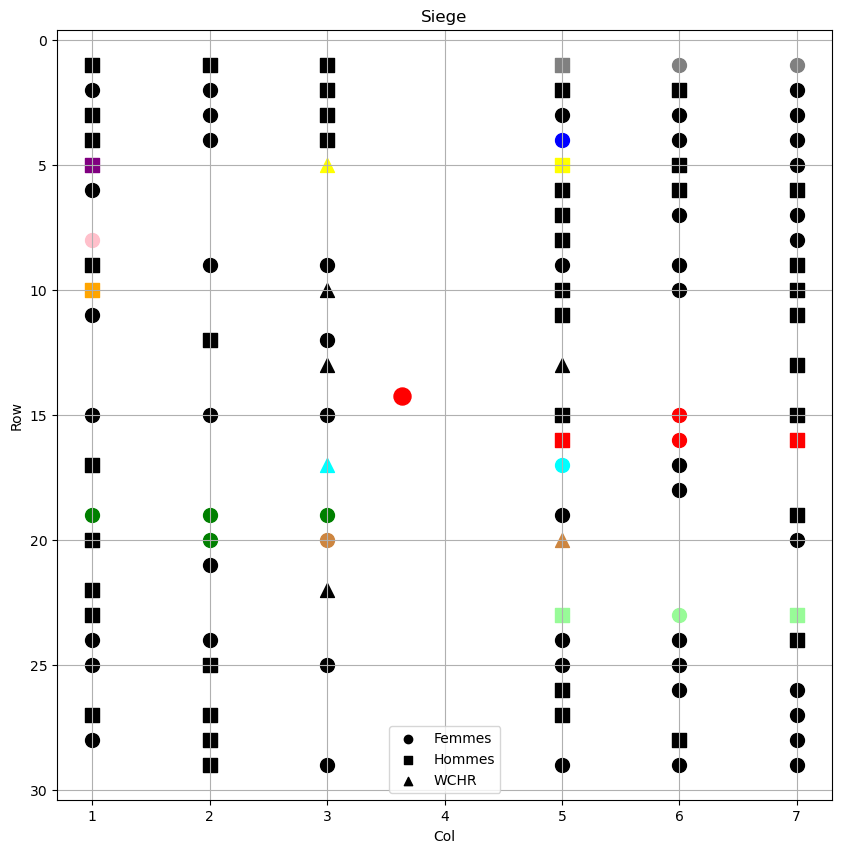

In [46]:
# Creating a variable called seats containing only the j coordinates
seats = [j for i in range(1, n + 1) for j in range(1, ns + 1) if S[(i, j)].x]
seat_coords = seat_coordinates(seats)


# Display the Baricenter

def calculate_center_of_mass(seat_coords, Passengers):
    x_g = LinExpr()
    y_g = LinExpr()
    total_weight = quicksum(Passengers[i]['weight'] for i in range(1, n + 1)).getValue()

    for i in range(1, n + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = Passengers[i]['weight'] / total_weight

            if (j % 7 == 0):
                x_g += (7 * S[i, j] * weight_ij)
                y_g += (j_k * S[i, j] * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += (((j // 7) + 1) * S[i, j] * weight_ij)

    return x_g, y_g


x_g, y_g = calculate_center_of_mass(seat_coords, Passengers)



# Dictionary to count the frequency of each group
group_counts = defaultdict(int)

# Counting the frequency of each group
for passenger in Passengers.values():
    group_counts[passenger['group']] += 1
# Sort the groups by the number of passengers in each group in descending order
sorted_groups = sorted(group_counts.items(), key=lambda x: x[1], reverse=True)

# Print the groups in ascending order with the number of passengers in each group
#print("Groups in ascending order with the number of passengers in each group:")
#for group, count in sorted_groups:
#    print(f"Group {group}: {count} passengers")

# Define shapes for each gender
shapes = {
    'Femmes': 'o',   # Circule
    'Hommes': 's',   # Square
    'WCHR': '^'      # Triangule
}

# Define colors for the groups with 3 passangers
colors = {
    1: 'red',
    4: 'green',
    5: 'blue',
    14: 'orange',
    23: 'purple',
    46: 'gray',
    3: 'yellow',
    10: 'cyan',
    17: 'peru',
    19:'palegreen',
    2: 'pink'
}

plt.figure(figsize=(10, 10))
for idx, coord in enumerate(seat_coords):
    group = Passengers[idx + 1]['group']
    gender = Passengers[idx + 1]['gender']
    color = colors.get(group, 'black')  # Get color for the group, default to black if not in colors dictionary
    shape = shapes.get(gender, 'o')      # Get shape for the gender, default to circle if not in shapes dictionary
    plt.scatter(coord[0], coord[1], color=color, marker=shape,  s=100)  # Use marker parameter to set the shape
    
# Add labels for each gender
for gender, shape in shapes.items():
    plt.scatter([], [], color='black', marker=shape, label=gender)  # Create invisible scatter plot to add label

# Plotting the center of mass
plt.scatter(x_g.getValue(), y_g.getValue(), color='red', marker='o', s=150)  # Larger red point for center of mass

plt.xlabel('Col')
plt.ylabel('Row')
plt.title('Siege')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()  # Show legend with gender labels
plt.show()

Evaluation de la satisfaction client

Première métrique qui évalue la satisfaction des passagers pris un par un.
Donc même si le groupe n'est pas bien groupé, si le passager est assis à côté d'au moins un des membres de son groupe, il est satisfait.

In [35]:
#Première métrique de la satisfaction client (chaque passager pris individuellement)
def metrique_groupe_passager():
    sat={}
    s=0
    for i in Passengers:
        sat[i]=0
        for k in Passengers :
            if k !=i and Passengers[i]['group'] == Passengers[k]['group']:
                for j in range (1, ns+1):
                    if S[(i,j)].x:
                        xi, yi = seat_coordinates([j])[0]
                    if S[(k,j)].x:
                        xk, yk = seat_coordinates([j])[0]
                if yi == yk and min([xi, xk]) == max([xi, xk])-1:
                    s = 1
                elif xi == xk and min([yi, yk]) == max([yi, yk])-1:
                    s = 1/2
                elif yi == yk and min([xi, xk]) == 3 and max([xi, xk]) == 5:
                    s = 1/2
            if sat[i] != 1:
                sat[i] = s
    
    return sat

print ( metrique_groupe_passager()) 

def metrique_transit_passager():
    sat= {}

    for i in Passengers:
        #On ne considère que les passagers dont le temps de correspondance est inférieur à 1h30
        if Passengers[i]['connection_time'] > 0 and Passengers[i]['connection_time'] <= 90: 
            for j in range (1, ns+1):
                
                if S[(i,j)].x:
                    x, y = seat_coordinates([j])[0]
                    if y <=5:
                        sat[i] = 1
                    elif y <= 7:
                        sat[i] = 0.5
                    else:
                        sat[i] =0
        else :
            sat[i]=1
                
    return sat
print (metrique_transit_passager()) 

def metrique_globale_passager():

    sat={}
    sat1=metrique_transit_passager()
    sat2=metrique_groupe_passager()
    satisfaction=0
     

    for i in Passengers:
        sat[i]=(sat1[i]+sat2[i])/2
        satisfaction +=sat[i]
    satisfaction = satisfaction/len(Passengers)

    return satisfaction, sat

satisfaction, sat= metrique_globale_passager()

print ("La satisfaction moyenne des clients est de ",satisfaction*100, "%" )

{1: 0.5, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0.5, 8: 0.5, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 0.5, 17: 0.5, 18: 0.5, 19: 0.5, 20: 0.5, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 0.5, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 0.5, 77: 0.5, 78: 0.5, 79: 0.5, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1, 101: 1, 102: 1, 103: 1, 104: 1, 105: 1, 106: 1, 107: 1, 108: 1, 109: 1, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1}
{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 2

Deuxième métrique : la satisfaction est évaluée à l'échelle du groupe et de manière strice, c'est à dire que certaines configurations sont jugées satisfaisantes, les autres ne l'étant pas.

In [36]:
#renvoie une liste contenant les indices des passagers dans le groupe de i
def groupe(i, Passengers):
    G=[]
    for k in range(1, n+1):
        if Passengers[i]['group'] == Passengers[k]['group']:
            G+=[k]
    return G


In [37]:
#renvoie un dictionnaire dont les groupes sont les clefs et les passagers du groupe les valeurs
def group_dict(Passengers):

    dic={}
    for i in Passengers:
        groupi=groupe(i, Passengers)
        k=Passengers[i]['group']
        if k not in dic:
            dic[k]=groupi
    return dic

print (group_dict(Passengers))
  

{1: [1, 2, 3, 4], 2: [5], 3: [6, 7], 4: [8, 9, 10, 11], 5: [12], 6: [13, 14], 7: [15, 16], 8: [17], 9: [18], 10: [19, 20], 11: [21, 22, 23, 24, 25], 12: [26], 13: [27], 14: [28], 15: [29, 30], 16: [31], 17: [32, 33], 18: [34, 35], 19: [36, 37, 38], 20: [39], 21: [40], 22: [41], 23: [42], 24: [43, 44], 25: [45], 26: [46], 27: [47], 28: [48, 49], 29: [50], 30: [51], 31: [52, 53], 32: [54], 33: [55], 34: [56], 35: [57], 36: [58, 59, 60], 37: [61, 62], 38: [63], 39: [64], 40: [65], 41: [66], 42: [67], 43: [68], 44: [69], 45: [70], 46: [71, 72, 73], 47: [74], 48: [75, 76], 49: [77], 50: [78], 51: [79], 52: [80, 81, 82], 53: [83], 54: [84], 55: [85], 56: [86], 57: [87], 58: [88], 59: [89, 90, 91], 60: [92, 93], 61: [94], 62: [95], 63: [96], 64: [97], 65: [98], 66: [99], 67: [100, 101], 68: [102], 69: [103], 70: [104], 71: [105], 72: [106, 107], 73: [108], 74: [109, 110], 75: [111], 76: [112], 77: [113], 78: [114], 79: [115]}


In [38]:
def metrique_groupe_stricte (Passengers):
    sat={}
    
    group=group_dict(Passengers)

    for g in group:
        seats = [j for i in group[g] for j in range(1, ns + 1) if S[(i, j)].x]
        group_coord=seat_coordinates(seats)

        X=[]
        Y=[]
        for i in range (len(group[g])):
            X += [group_coord [i][0]]
            Y += [group_coord [i][1]]
            X.sort()
            Y.sort()

        if len(group[g]) == 1:
            sat[g] = 1

        #Groupe de 2 passagers : ils doivent être côte à côte. Satisfaction intermédiaire si séparés par allée centrale
        if len(group[g]) == 2:
            if Y[0] == Y[1]:
                if X[1] == X[0]+1:
                    sat[g] = 1
                elif (3 in X and 5 in X):
                    sat[g] = 1/2
                else : 
                    sat[g] = 0

            else : 
                sat[g] = 0

        #Groupe de 3 : aligné sur le même rang. Satisfaction max si côtes à côtes, intermédiaire si séparés par allée centrale, nulle sinon
        elif len(group[g]) == 3:
            if Y[0] == Y[1] and Y[0] == Y[2]:
                if X[1] == X[0]+1 and X[2] == X[1]+1:
                    sat[g] = 1

                elif (X[1] == X[0]+1 or X[2] == X[1]+1) and(3 in X and 5 in X):
                    sat[g] = 1/2
                else : 
                    sat[g] = 0
            else : 
                sat[g] = 0

        #Groupe de 4 à 6 personnes
        elif len(group[g]) <=6 :
            if all(y == Y[0] for y in Y):
                
                if X[len(group[g])-1]-X[0] == len(group):
                    sat[g]=1
                else:
                    sat[g]=1
            
            elif Y[1]==Y[0]+1:
                if (3 in X and 5 not in X) or (5 in X and 3 not in X):
                    sat[g]=1/2
                else:
                    sat[g]=0
            else :
                sat[g]=0   
                
        else:
            sat[g]=1


    return sat        
            

In [39]:
#Retourne une note sur 1 par passager concernant l'objectif de transit
def metrique_transit_stricte(Passengers):

    sat= {}
    

    for i in Passengers:
        #On ne considère que les passagers dont le temps de correspondance est inférieur à 1h30
        if Passengers[i]['connection_time'] > 0 and Passengers[i]['connection_time'] <= 90: 
            for j in range (1, ns+1):
                
                if S[(i,j)].x:
                    x, y = seat_coordinates([j])[0]
                    if y <=5:
                        sat[i] = 1
                    elif y <= 7:
                        sat[i] = 1/2
                    elif y <= 10:
                        sat[i] = 1/3
                    else:
                        sat[i] =0
        else :
            sat[i]=1
                
    return sat



In [40]:
def metrique_globale_stricte(Passengers):
    sat={}
    moyenne=0
    sat_groupe=0
    sat_transit=0
    #Pour fusionner les notes des passagers au regard des deux fonctions objectif, on transforme les notes par groupe pour la fonction groupe en note par passager
    sat1={}
    s=metrique_groupe_stricte (Passengers)
    group_dico=group_dict(Passengers)
    for g in group_dico:
        sat_groupe += s[g]
        passagers = group_dico[g]
        for i in passagers:
            sat1[i]=s[g]

    sat2=metrique_transit_stricte(Passengers)

    for i in Passengers:
        sat[i]=(sat1[i] + sat2[i])/2
        moyenne += sat[i]
        sat_transit += sat2[i]
        

    moyenne = moyenne / len(Passengers)
    sat_groupe = sat_groupe / len(s)
    sat_transit =sat_transit / len(Passengers)
    # print (list(sat.values()))
    # m=min(list(sat.values()))
    # M=max(list(sat.values()))
    return moyenne, sat_transit, sat_groupe

    
    

In [41]:


moyenne, s_transit, s_groupe = metrique_globale_stricte(Passengers)

# print ("Le pire niveau de satisfaction est de ", m*100, "%")
# print ("Le meilleur niveau de satisfaction est de ", M*100, "%")
print ("La satisfaction moyenne des passagers est de ", moyenne*100, "%")
print ("La satisfaction moyenne des passagers en transit est de ", s_transit)
print ("La satisfaction moyenne des groupes est de ", s_groupe)



La satisfaction moyenne des passagers est de  93.04347826086956 %
La satisfaction moyenne des passagers en transit est de  1.0
La satisfaction moyenne des groupes est de  0.9367088607594937


Troisième métrique : "bounding box"

In [42]:
def ponderation(x,y):

    beta= 0.3
    den = (1-beta)*x + beta*y + 1
   
    res = (1/den)*5

    return res


def metrique_retangule(passengers):
    satisfaction_scores = 0 
    group_scores = {}  

    for i in passengers:
        group = groupe(i, passengers)
        group_coords = [seat_coords[idx - 1] for idx in group]  


        min_x = min(coord[0] for coord in group_coords)
        max_x = max(coord[0] for coord in group_coords)


        min_y = min(coord[1] for coord in group_coords)
        max_y = max(coord[1] for coord in group_coords)
       
        y_distance = max_y - min_y
        x_distance = max_x - min_x

        if x_distance == len(group)  and y_distance == 0:
            group_scores[i] = 5
            satisfaction_scores += 5 
        else:
            score = ponderation(x_distance, y_distance)
            group_scores[i] = score
            satisfaction_scores += score

    return satisfaction_scores/len(Passengers), group_scores


metrique_retangule(Passengers)

(3.8698257080609997,
 {1: 1.8518518518518516,
  2: 1.8518518518518516,
  3: 1.8518518518518516,
  4: 1.8518518518518516,
  5: 5.0,
  6: 5,
  7: 5,
  8: 1.8518518518518516,
  9: 1.8518518518518516,
  10: 1.8518518518518516,
  11: 1.8518518518518516,
  12: 5.0,
  13: 2.9411764705882355,
  14: 2.9411764705882355,
  15: 5,
  16: 5,
  17: 5.0,
  18: 5.0,
  19: 5,
  20: 5,
  21: 1.8518518518518516,
  22: 1.8518518518518516,
  23: 1.8518518518518516,
  24: 1.8518518518518516,
  25: 1.8518518518518516,
  26: 5.0,
  27: 5.0,
  28: 5.0,
  29: 2.9411764705882355,
  30: 2.9411764705882355,
  31: 5.0,
  32: 5,
  33: 5,
  34: 2.9411764705882355,
  35: 2.9411764705882355,
  36: 2.0833333333333335,
  37: 2.0833333333333335,
  38: 2.0833333333333335,
  39: 5.0,
  40: 5.0,
  41: 5.0,
  42: 5.0,
  43: 2.9411764705882355,
  44: 2.9411764705882355,
  45: 5.0,
  46: 5.0,
  47: 5.0,
  48: 2.9411764705882355,
  49: 2.9411764705882355,
  50: 5.0,
  51: 5.0,
  52: 2.9411764705882355,
  53: 2.9411764705882355,
 